In [32]:

from dotenv import load_dotenv

load_dotenv()

True

In [33]:
from langchain_community.utilities.sql_database import SQLDatabase

# Correct the path to point to the database
db = SQLDatabase.from_uri("sqlite:///../data/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [34]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo-preview")

In [35]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig

# Tools

In [36]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage

## Customer

In [37]:
# To eagerly pop

@tool
def get_user_info(config: RunnableConfig) -> dict:
    """
    Retrieve customer information from the 'customers' table
    using a 'customer_id' read from 'config["configurable"]["customer_id"]'.

    If the record is found, returns a dictionary of column_name -> value.
    Otherwise, returns {'error': ...}.

    Example usage:
    --------------
    config = {"configurable": {"customer_id": 1}}
    result = get_user_info.invoke(config)

    The function will look up the customer with ID=1.
    """
    configuration = config.get("configurable", {})
    customer_id = configuration.get("customer_id", None)
    if not customer_id:
        raise ValueError("No customer_id configured in config['configurable'].")

    # Connect to your DB
    conn = sqlite3.connect("../data/chinook.db")
    cursor = conn.cursor()

    # Query the customer row
    query = "SELECT * FROM customers WHERE CustomerID = ?"
    cursor.execute(query, (customer_id,))
    row = cursor.fetchone()
    column_names = [desc[0] for desc in cursor.description] if cursor.description else []

    if row:
        # Convert the tuple row to a dictionary
        row_dict = dict(zip(column_names, row))
        result = row_dict
    else:
        result = {"error": f"No customer found with ID {customer_id}"}

    cursor.close()
    conn.close()

    return result

In [38]:
# Define the tool for looking up customer information
@tool
def get_customer_info(customer_id: int):
    """
    Retrieve customer information from the database using their unique customer ID.

    This tool queries the 'customers' table in the Chinook database to fetch information 
    about a specific customer. It is essential to ensure that the customer ID is provided 
    and is valid before invoking this function.

    Parameters:
    ----------
    customer_id : int
        The unique identifier for the customer in the database.


    Returns:
    -------
    list or dict
        If a customer record is found, returns a list containing one tuple (the row).
        If no record is found or there's an error, returns a dict with an "error" key.
        
    Notes:
    ------
    - ALWAYS confirm that the customer ID is available and valid before calling this function.
    - If the customer ID is invalid or does not exist, the function will return an appropriate 
      error message.
    - Example usage:
        `get_customer_info(1)` will information for the customer with ID 1.
    """
    # Validate that a customer ID is provided
    if not isinstance(customer_id, int) or customer_id <= 0:
        return {"error": "Invalid customer ID. Please provide a valid positive integer."}
    
    # Query the database for customer information
    try:
        result = db.run(f"SELECT * FROM customers WHERE CustomerID = {customer_id};")
        if result:
            return result
        else:
            return {"error": f"No customer found with ID {customer_id}."}
    except Exception as e:
        return {"error": f"An error occurred while fetching customer info: {str(e)}"}
    

import sqlite3

@tool
def update_customer_profile(customer_id: int, field: str, new_value: str):
    """
    Update a specific field in a customer's profile.

    Parameters:
    ----------
    customer_id : int
        The unique identifier for the customer in the database.
    field : str
        The name of the field to update (e.g., 'FirstName', 'LastName', 'Email').
    new_value : str
        The new value to update in the specified field.

    Returns:
    -------
    dict
        A dictionary containing a success message or an error message.
    """
    print(f"Received inputs - Customer ID: {customer_id}, Field: {field}, New Value: {new_value}")

    # Validate inputs
    if not isinstance(customer_id, int) or customer_id <= 0:
        return {"error": "Invalid customer ID. Please provide a valid positive integer."}

    valid_fields = [
        "FirstName", "LastName", "Company", "Address", "City", "State",
        "Country", "PostalCode", "Phone", "Fax", "Email", "SupportRepId"
    ]
    if field not in valid_fields:
        return {"error": f"Invalid field '{field}'. Allowed fields are: {', '.join(valid_fields)}"}
    
    if not isinstance(new_value, str) or len(new_value.strip()) == 0:
        return {"error": "Invalid value. Please provide a valid new value."}

    try:
        # Connect to the database directly
        conn = sqlite3.connect("../data/chinook.db")  
        cursor = conn.cursor()

        # Parameterized query
        query = f"UPDATE customers SET {field} = ? WHERE CustomerID = ?;"
        print(f"Executing query: {query} with params: ({new_value}, {customer_id})")

        # Execute query
        cursor.execute(query, (new_value, customer_id))
        conn.commit()  # Commit the changes
        rows_affected = cursor.rowcount

        cursor.close()
        conn.close()

        # Check if the update was successful
        if rows_affected == 0:
            return {"error": f"No rows updated. Ensure Customer ID {customer_id} exists in the database."}
        
        return {"success": f"{field} for customer ID {customer_id} updated to '{new_value}'."}

    except sqlite3.Error as e:
        error_message = f"An error occurred while updating the field '{field}': {str(e)}"
        print(f"Error details: {error_message}")
        return {"error": error_message}

    except Exception as e:
        print(f"Unhandled exception: {str(e)}")
        return {"error": "An unexpected error occurred."}

## Music

In [39]:
from langchain_community.vectorstores import SKLearnVectorStore
from langchain.embeddings.openai import OpenAIEmbeddings

def create_music_retrievers(database):
    """
    Create retrievers for looking up artists and tracks using approximate matching.

    This function uses a vector-based search mechanism to create retrievers for artists and 
    track names from the Chinook database. It enables efficient and error-tolerant lookups 
    of artist and track names without requiring exact spelling.

    Parameters:
    ----------
    database : SQLDatabase
        An instance of the SQLDatabase connected to the Chinook database.

    Returns:
    -------
    tuple
        A tuple containing:
        - artist_retriever: A retriever for searching artist names.
        - song_retriever: A retriever for searching track names.

    Notes:
    ------
    - The function queries the database for artists and tracks, retrieves their names, 
      and indexes them into separate retrievers.
    - OpenAI embeddings are used for generating vector representations of the names.
    - The retrievers allow for approximate matching, making it user-friendly for misspelled 
      or partially remembered artist/track names.

    Example Usage:
    --------------
        db = SQLDatabase.from_uri("sqlite:///../data/chinook.db")
        artist_retriever, song_retriever = create_music_retrievers(db)
    """
    try:
        # Query the database for artists and tracks
        artists = database._execute("SELECT * FROM artists")
        songs = database._execute("SELECT * FROM tracks")

        # Validate query results
        if not artists:
            raise ValueError("No artists found in the database.")
        if not songs:
            raise ValueError("No tracks found in the database.")

        # Extract artist and track names for embedding
        artist_names = [artist['Name'] for artist in artists]
        track_names = [track['Name'] for track in songs]

        # Create retrievers for artists and songs
        artist_retriever = SKLearnVectorStore.from_texts(
            texts=artist_names,
            embedding=OpenAIEmbeddings(),
            metadatas=artists
        ).as_retriever()

        song_retriever = SKLearnVectorStore.from_texts(
            texts=track_names,
            embedding=OpenAIEmbeddings(),
            metadatas=songs
        ).as_retriever()

        return artist_retriever, song_retriever

    except Exception as e:
        raise RuntimeError(f"Error creating music retrievers: {str(e)}")
    
    

In [40]:
# Define global variables
artist_retriever = None
song_retriever = None

def initialize_retrievers(database):
    global artist_retriever, song_retriever
    artist_retriever, song_retriever = create_music_retrievers(database)

# Call this once during setup
initialize_retrievers(db)

In [41]:
@tool
def get_albums_by_artist(artist_name: str):
    """
    Retrieve a list of albums by a given artist or similar artists using approximate matching.

    This tool leverages the `artist_retriever` to find artists whose names closely match 
    the provided input and then queries the database to get the albums associated with 
    those artists.

    Parameters:
    ----------
    artist_name : str
        The name of the artist to search for.

    Returns:
    -------
    list
        A list of dictionaries, where each dictionary contains:
        - Title: The album title.
        - Name: The artist's name.

    Notes:
    ------
    - If no matching artists are found, an appropriate message will be returned.
    - Uses approximate matching via the `artist_retriever` to handle typos and partial matches.
    - Example usage:
        `get_albums_by_artist("The Beatles")` retrieves albums for "The Beatles" or similar artists.

    Example Response:
    -----------------
        [
            {"Title": "Revolver", "Name": "The Beatles"},
            {"Title": "Abbey Road", "Name": "The Beatles"}
        ]
    """
    try:
        # Find relevant artists using the retriever
        docs = artist_retriever.get_relevant_documents(artist_name)
        
        # Check if any artists were found
        if not docs:
            return {"error": f"No artists found matching '{artist_name}'. Please try another name."}
        
        # Extract artist IDs from the retrieved documents
        artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
        
        # Query the database for albums by the retrieved artists
        query = f"""
        SELECT 
            albums.Title AS Title, 
            artists.Name AS Name 
        FROM 
            albums 
        LEFT JOIN 
            artists 
        ON 
            albums.ArtistId = artists.ArtistId 
        WHERE 
            albums.ArtistId IN ({artist_ids});
        """
        result = db.run(query, include_columns=True)
        
        # Check if any albums were found
        if not result:
            return {"message": f"No albums found for artists similar to '{artist_name}'."}
        
        return result

    except Exception as e:
        return {"error": f"An error occurred while fetching albums: {str(e)}"}

In [42]:
@tool
def get_tracks_by_artist(artist_name: str):
    """
    Retrieve a list of tracks by a given artist or similar artists using approximate matching.
    """
    # Validate retriever initialization
    if artist_retriever is None:
        return {"error": "Artist retriever is not initialized. Please ensure the retrievers are set up."}

    try:
        # Retrieve relevant artists using the retriever
        docs = artist_retriever.get_relevant_documents(artist_name)
    
        artist_ids = ", ".join([str(doc.metadata["ArtistId"]) for doc in docs])
        
        # Query the database for tracks by the retrieved artists (case-insensitive)
        query = f"""
        SELECT 
            tracks.Name AS SongName, 
            artists.Name AS ArtistName 
        FROM 
            albums 
        LEFT JOIN 
            artists 
        ON 
            albums.ArtistId = artists.ArtistId 
        LEFT JOIN 
            tracks 
        ON 
            tracks.AlbumId = albums.AlbumId 
        WHERE 
            LOWER(artists.Name) = LOWER('{artist_name}')
            OR albums.ArtistId IN ({artist_ids});
        """
        result = db.run(query, include_columns=True)
        
        if not result:
            return {"message": f"No tracks found for artists similar to '{artist_name}'."}
        
        return result

    except Exception as e:
        return {"error": f"An error occurred while fetching tracks: {str(e)}"}

In [43]:
@tool
def check_for_songs(song_title: str):
    """
    Search for songs by title using approximate matching.

    This tool uses the `song_retriever` to find songs whose titles closely match 
    the provided input. It returns relevant information about the songs.

    Parameters:
    ----------
    song_title : str
        The title of the song to search for.

    Returns:
    -------
    list
        A list of dictionaries with song details or a message if no matches are found.

    Notes:
    ------
    If no exact match is found, it returns similar titles.
    """
    try:
        # Retrieve relevant songs using the retriever
        songs = song_retriever.get_relevant_documents(song_title)
        
        # Check if any songs were found
        if not songs:
            return {"message": f"No songs found matching '{song_title}'. Please try another title."}
        
        return songs

    except Exception as e:
        return {"error": f"An error occurred while searching for songs: {str(e)}"}
    



# Create Assistants

In [44]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "music", 
                "customer"
            ]
        ],
        update_dialog_stack,
    ]

In [45]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from pydantic import BaseModel, Field

llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo-preview")


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


extra_customer_security = """
You will be given the customer data when the chats begins. Do not ask them for any clarification. 
Do not under any circumstance share customer information of another customer. 
IMPORTANT: If the customer wants to make any modification to their profile, you must ask them to confirm their current email and phone number.  
IMPORTANT: If the customer wants to inquire about the information that you have for them on file, you must ask them to confirm their current email and phone number.
                        """

customer_assistance_prompt = ChatPromptTemplate.from_messages(
    [
        (   "system",
            """
            Your role is to assist a user in viewing or updating their profile information.

            You have access to the following tools to perform these tasks:
            1. `get_customer_info`: Retrieve information about a specific customer using their unique customer ID.
            - Required input: `customer_id`
            - Example: "What is your customer ID so I can retrieve your profile?"

            2. `update_customer_profile`: Update a specific field in the customer's profile.
            - Required inputs:
                - `customer_id`: The unique ID of the customer.
                - `field`: The name of the profile field to update (e.g., "FirstName", "Email", "Phone").
                - `new_value`: The new value to assign to the specified field.
            - Example: "Could you confirm your customer ID and provide the new email address you'd like to update?"

            Steps to assist the user:
            - Always verify you have all the required inputs before using a tool.
            - If a user wants to update a field (e.g., their email or phone number), ask for the relevant inputs:
            - For first name updates: Ask for the new first name.
            - For email updates: Ask for the new email address.
            - For phone updates: Ask for the new phone number.
            - For other fields: Clarify the field name and the new value.

            Example interactions:
            1. To retrieve profile information:
            - "What is your customer ID so I can look up your profile?"
            2. To update the profile:
            - "What is your customer ID, and which field would you like to update? Please provide the new value for that field."

            Important Notes:
            - If the user requests to update a field that is invalid or unavailable, inform them politely of the valid fields:
            - Allowed fields: `FirstName`, `LastName`, `Company`, `Address`, `City`, `State`, `Country`, `PostalCode`, `Phone`, `Fax`, `Email`, and `SupportRepId`.
            - If you are unable to assist with the user's request, politely suggest they contact customer support.

            If the user provides all necessary inputs, proceed to execute the appropriate tool and confirm the changes.
            """ + extra_customer_security,
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

customer_safe_tools = [get_customer_info]
customer_sensitive_tools = [update_customer_profile]
customer_tools = customer_safe_tools + customer_sensitive_tools
customer_runnable = customer_assistance_prompt | llm.bind_tools(
    customer_tools + [CompleteOrEscalate]
)

# Music
music_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Your job is to assist a customer in finding any songs they are looking for.

            You have access to specific tools to look up songs, albums, or artists. If a customer asks for something you cannot assist with, 
            politely inform them of the limitations and let them know what you can help with.


            When looking up artists and songs, sometimes the exact match may not be found. In such cases, the tools are designed to return 
            information about similar songs or artists. This is intentional and helps provide relevant recommendations.
            """,
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

music_tools = [check_for_songs, get_tracks_by_artist, get_albums_by_artist]
music_tools
music_runnable = music_prompt | llm.bind_tools(
    music_tools + [CompleteOrEscalate]
)

## Primary Assistant

In [46]:
class Router(BaseModel):
    """
    A routing model responsible for determining the appropriate agent
    to handle user inquiries based on the context of their message.

    Attributes:
    ----------
    choice : str
        Specifies the agent to route to. Should be one of:
        - 'music' for inquiries related to music recommendations or music information.
        - 'customer' for inquiries related to updating or accessing user information.
    """
    choice: str = Field(description="Should be one of: 'music', 'customer'.")

In [47]:
class ToCustomerAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle customer profile queries."""

    request: str = Field(
        description="Any necessary followup questions to retrieve or update customer information should clarify before proceeding."
    )

In [48]:
class ToMusicAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle music-related queries."""

    request: str = Field(
        description="Any necessary followup questions to give information about music should clarify before proceeding."
    )

In [49]:
# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.
# The task delegation is a simple form of semantic routing / does simple intent detection

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Your job is to serve as a polite and helpful customer service representative for a music store.

            You can assist customers in the following ways:
            1. **Updating user information**:
                - If the customer wants to update or access their information in the user database, route them to `customer`.
            2. **Recommending music**:
                - If the customer wants to find music or learn about music, route them to `music`.

            Routing Instructions:
            - If the user mentions updating or accessing their personal information, call the router with 'customer'.
            - If the user mentions music recommendations or any music-related inquiry, call the router with 'music'.
            - For any other inquiries, respond politely and explain what you can assist with.

            Always aim to be polite and clear in your interactions.
            """,
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)
primary_assistant_tools = [
    Router
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    
    primary_assistant_tools + 

    [
        ToMusicAssistant,
        ToCustomerAssistant,
    ]
)

### Create Assistant

#### Utility

In [50]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and any other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

# Building Graph

In [51]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.graph import START, END
import uuid

from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableLambda


builder = StateGraph(State)


def user_info(state: State) -> State:
    """
    Retrieve a customer_id from state["configurable"]["customer_id"],
    call get_user_info with the correct 'RunnableConfig' signature,
    and store the result in state["user_info"].
    """
    return {"user_info": get_user_info.invoke({})}
    
    
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

### Music Assistant

In [52]:
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)]
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [53]:
# Flight booking assistant
builder.add_node(
    "enter_music",
    create_entry_node("Music Assistant", "music"),
)
builder.add_node("music", Assistant(music_runnable))

builder.add_edge("enter_music", "music")


builder.add_node(
    "music_tools",
    create_tool_node_with_fallback(music_tools),
)


def route_music(state: State):
    route = tools_condition(state)
    if route == END:
        return END
    
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    
    if did_cancel:
        return "leave_skill"

    # Route directly to music_tools if only one group exists
    safe_toolnames = [t.name for t in music_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "music_tools"
    return "music_tools"  


builder.add_edge("music_tools", "music")


builder.add_conditional_edges(
    "music",
    route_music,
    ["music_tools", "leave_skill", END],
)



# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [54]:
builder.add_node(
    "enter_customer_profile",
    create_entry_node("Customer Assistant", "customer_assistant"),
)
builder.add_node("customer_assistant", Assistant(customer_runnable))
builder.add_edge("enter_customer_profile", "customer_assistant")
builder.add_node(
    "customer_safe_tools",
    create_tool_node_with_fallback(customer_safe_tools),
)
builder.add_node(
    "customer_sensitive_tools",
    create_tool_node_with_fallback(customer_sensitive_tools),
)


def route_customer_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in customer_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "customer_safe_tools"
    return "customer_sensitive_tools"


builder.add_edge("customer_sensitive_tools", "customer_assistant")
builder.add_edge("customer_safe_tools", "customer_assistant")
builder.add_conditional_edges(
    "customer_assistant",
    route_customer_assistant,
    [
        "customer_safe_tools",
        "customer_sensitive_tools",
        "leave_skill",
        END,
    ],
)

### Primary Assistant

In [55]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToCustomerAssistant.__name__:
            return "enter_customer_profile"
        elif tool_calls[0]["name"] == ToMusicAssistant.__name__:
            return "enter_music"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_customer_profile",
        "enter_music",
        "primary_assistant_tools",
        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "music",
    "customer_assistant"
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "customer_sensitive_tools"
    ],
)

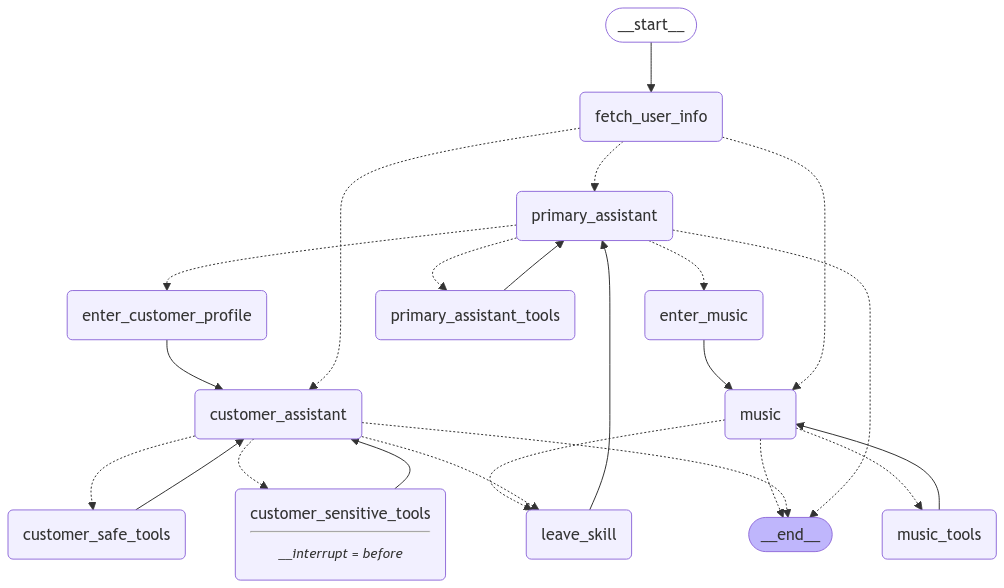

In [56]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Test

In [57]:
tutorial_questions = [
    # "Hi there, do you have any songs by the Foo Fighters?",
    # "What information do you have for me on file? My customer ID is 1", 
    # "Do you have any songs from Amy Winehouse?", 
    "I would like to change my email to dontchange@gmail.com. My customer ID is 1.",
    # "What Pink Floyd albums do you have available?", 
    # "Do you have Money by Pink Floyd?"
]

# Test out manually

In [66]:
import json
import uuid
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
import ast

# 1) Load config from JSON, add thread_id at runtime
with open("config.json", "r") as f:
    config_data = json.load(f)

thread_id = str(uuid.uuid4())
config_data["configurable"]["thread_id"] = thread_id
# 2) Initialize the graph with an empty input to populate the state
graph.invoke({"messages": []}, config_data)  # Trigger the graph's first node

# 3) Retrieve the user_info from the state
snapshot = graph.get_state(config_data)
user_info_data = snapshot.values["user_info"]

# 4) Build a single system message that references the user’s info
system_msg = SystemMessage(
    content=(
        f"You are an AI Chatbot. You are speaking with this customer: {user_info_data}, "
        f"a valued customer. Greet them by name. Pay attention to their unique customer ID: {user_info_data['CustomerId']}."
    )
)

def print_latest_event(events, user_input=None):
    """
    Helper to print only the most recent AI message and the user's input.
    It skips repeated system or irrelevant responses.
    """
    latest_message = None

    for event in events:
        if "messages" in event:
            for msg in event["messages"]:
                if isinstance(msg, AIMessage):  # Focus on AI responses
                    latest_message = f"ASSISTANT: {msg.content}"
                elif isinstance(msg, ToolMessage):  # Include tool updates if relevant
                    latest_message = f"TOOL: {msg.content}"

    if user_input:
        print(f"YOU: {user_input}")
    if latest_message:
        print(latest_message)


# 5) Insert the system message once, then print the resulting greeting (if any)
init_result = graph.invoke({"messages": [system_msg]}, config_data)

# Print the AI's response (greeting) if it exists
if isinstance(init_result, dict):
    print_latest_event([init_result])

# 6) Start the interactive loop where the user can type
while True:
    user_input = input("YOU: ")
    if user_input.strip().lower() in {"q", "quit"}:
        print("Exiting chat. Goodbye!")
        break

    # Pass only the new user message to the graph
    events = graph.stream({"messages": [HumanMessage(content=user_input)]}, config_data, stream_mode="values")
    print_latest_event(events, user_input=user_input)

    # Check for interrupts as usual
    snapshot = graph.get_state(config_data)
    while snapshot.next:
        print("\n**INTERRUPT**: The chatbot wants to perform a sensitive action.\n")
        user_decision = input("Approve? (y/n or type changes): ").strip().lower()

        if user_decision == "y":
            resumed_output = graph.invoke(None, config_data)
            if isinstance(resumed_output, dict) and "messages" in resumed_output:
                print_latest_event([resumed_output])
        else:
            denial_msg = ToolMessage(
                content=f"Action denied by user. Reason: '{user_decision}'. Please adapt."
            )
            resumed_output = graph.invoke({"messages": [denial_msg]}, config_data)
            if isinstance(resumed_output, dict) and "messages" in resumed_output:
                print_latest_event([resumed_output])

        snapshot = graph.get_state(config_data)

    print("\n" + "=" * 40 + "\n")



-- Initial Assistant Response --

ASSISTANT: Hello Luís, how can I assist you today?

-- Done preloading system message into the state --

YOU: what songs do you have by foo fighters?
ASSISTANT: Here are some songs by Foo Fighters:

1. In Your Honor
2. No Way Back
3. Best Of You
4. DOA
5. Hell
6. The Last Song
7. Free Me
8. Resolve
9. The Deepest Blues Are Black
10. End Over End
11. Still
12. What If I Do?
13. Miracle
14. Another Round
15. Friend Of A Friend
16. Over And Out
17. On The Mend
18. Virginia Moon
19. Cold Day In The Sun
20. Razor
21. All My Life
22. Low
23. Have It All
24. Times Like These
25. Disenchanted Lullaby
26. Tired Of You
27. Halo
28. Lonely As You
29. Overdrive
30. Burn Away
31. Come Back
32. Doll
33. Monkey Wrench
34. Hey, Johnny Park!
35. My Poor Brain
36. Wind Up
37. Up In Arms
38. My Hero
39. See You
40. Enough Space
41. February Stars
42. Everlong
43. Walking After You
44. New Way Home

This is a selection of their tracks. If you're looking for a specific so